In [1]:
import torch
import random
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   ]
)


train_set = torchvision.datasets.ImageFolder("/content/drive/MyDrive/diabet/train", transform = transform)
test_set = torchvision.datasets.ImageFolder("/content/drive/MyDrive/diabet/test", transform = transform)

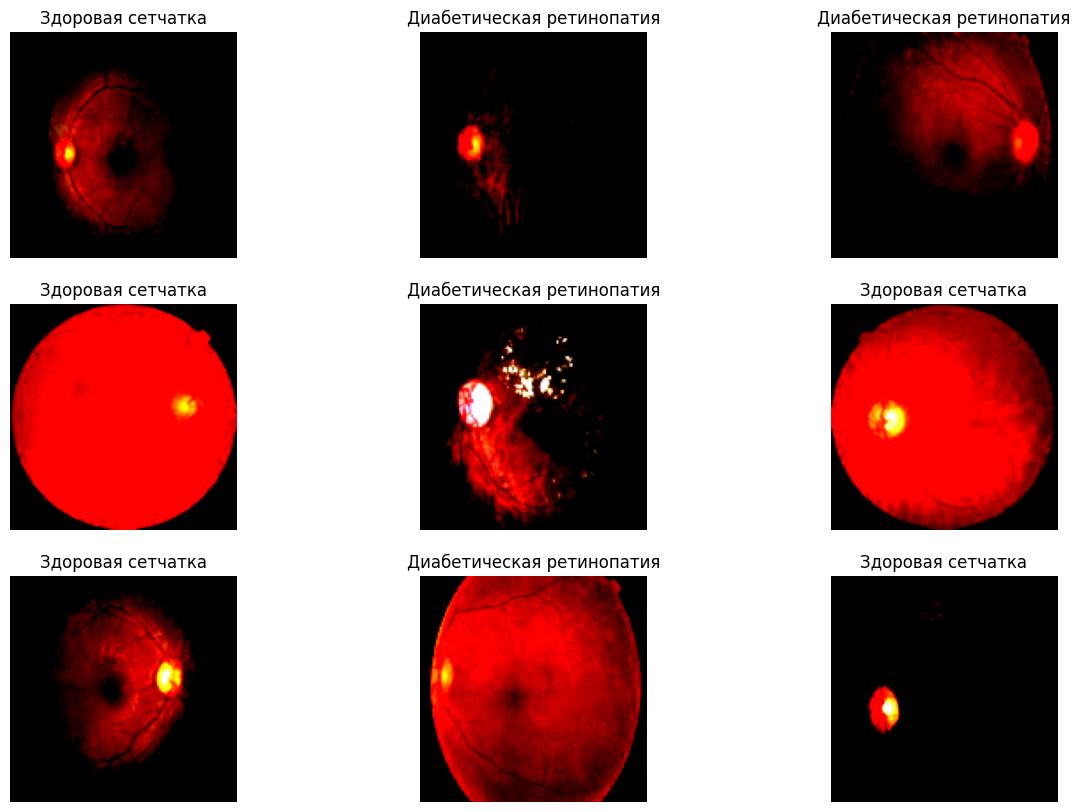

In [3]:
CLA_label = {
        0 : 'Диабетическая ретинопатия',
        1 : 'Здоровая сетчатка',
}
figure = plt.figure(figsize=(15, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
plt.show()

In [4]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
X_train = []
Y_train = []

for data, label in train_loader:
    X_train.append(data)
    Y_train.append(label)


train_loader = DataLoader(test_set, batch_size=32, shuffle=True)
X_test = []
Y_test = []

for data, label in train_loader:
    X_test.append(data)
    Y_test.append(label)

In [5]:
X_train = torch.cat(X_train, dim=0)
Y_train = torch.cat(Y_train, dim=0)
X_test = torch.cat(X_test, dim=0)
Y_test = torch.cat(Y_test, dim=0)

In [6]:
print(X_train.shape)

torch.Size([2076, 3, 128, 128])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(32 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 30)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

simple_cnn = SimpleCNN()

In [8]:
torch.cuda.is_available()

!nvidia-smi

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
simple_cnn = simple_cnn.to(device)
list(simple_cnn.parameters())

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=0.00001)

Fri Dec 15 10:27:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
%%time

batch_size = 32
test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
Y_test = Y_test.to(device)

for epoch in range(15):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        Y_batch = Y_train[batch_indexes].to(device)

        preds = simple_cnn.forward(X_batch)

        loss_value = loss(preds, Y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = simple_cnn.forward(X_test)


    test_loss_history.append(loss(test_preds, Y_test))

    accuracy = (test_preds.argmax(dim=1) == Y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.8831, device='cuda:0')
tensor(0.9351, device='cuda:0')
tensor(0.9437, device='cuda:0')
tensor(0.9264, device='cuda:0')
tensor(0.9437, device='cuda:0')
tensor(0.9437, device='cuda:0')
tensor(0.9437, device='cuda:0')
tensor(0.9481, device='cuda:0')
tensor(0.9481, device='cuda:0')
tensor(0.9394, device='cuda:0')
tensor(0.9567, device='cuda:0')
tensor(0.9351, device='cuda:0')
tensor(0.9481, device='cuda:0')
tensor(0.9524, device='cuda:0')
tensor(0.9437, device='cuda:0')
CPU times: user 8.15 s, sys: 174 ms, total: 8.33 s
Wall time: 12.5 s


In [12]:
torch.save(simple_cnn.state_dict(), 'trained_model_CNN.pth')